## Imports

In [1]:
import corner
import numpy as np
import bilby
import pandas as pd
import seaborn as sns
import glob

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint, ConditionalPriorDict, ConditionalUniform
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from priors import *

xp = gwpop.cupy_utils.xp

sns.set_theme(style="ticks")

colours = ["#01275B", "#FFAC3B", "#C7267C", "#357413"]

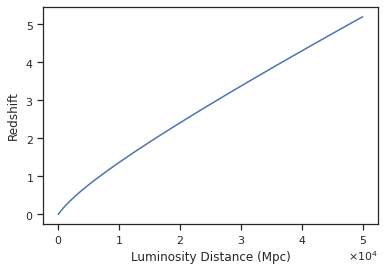

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1 * cost1 + a2 * q * cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)

luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

### Function for drawing posterior samples from LVC prior

In [3]:
def draw_prior_samples(nsamples, nevents):
    
    def p_conversion(parameters):
        parameters["mass_ratio"] = parameters["mass_2_det"]/parameters["mass_1_det"]
        return parameters
    
    def gen_samples(nsamples, nevents):
        posteriors_list = list()
        for i in range(nevents):
            _posterior = pd.DataFrame(priors.sample(nsamples))
            _posterior["redshift"] = dl_to_z(_posterior['luminosity_distance'])
            _posterior["mass_1"] = _posterior["mass_1_det"]/(1 + _posterior["redshift"])
            _posterior["mass_2"] = _posterior["mass_2_det"]/(1 + _posterior["redshift"])
            _posterior["mass_ratio"] = _posterior["mass_2"]/_posterior["mass_1"]
            _posterior["chi_eff"] = chieff(_posterior['a_1'], _posterior['a_2'], _posterior['mass_ratio'],
                                           _posterior['cos_tilt_1'], _posterior['cos_tilt_2'])
            _posterior["chi_p"] = chiP(_posterior['a_1'], _posterior['a_2'], _posterior['mass_ratio'],
                                       _posterior['cos_tilt_1'], _posterior['cos_tilt_2'])
            posteriors_list.append(_posterior)
        return posteriors_list
    
    priors = PriorDict(conversion_function = p_conversion)

    priors["mass_1_det"] = Uniform(minimum = 2., maximum = 100.)
    priors["mass_2_det"] = Uniform(minimum = 2., maximum = 100.)
    priors["mass_ratio"] = Constraint(minimum = 0., maximum = 1.)
    priors["a_1"] = Uniform(minimum = 0., maximum = 1.)
    priors["a_2"] = Uniform(minimum = 0., maximum = 1.)
    priors["cos_tilt_1"] = Uniform(minimum = -1., maximum = 1.)
    priors["cos_tilt_2"] = Uniform(minimum = -1., maximum = 1.)

    dl_max = Planck15.luminosity_distance(2.3).value
    priors["luminosity_distance"] = bilby.core.prior.PowerLaw(minimum = 0, maximum = dl_max, alpha=2)
    
    posteriors_list = gen_samples(nsamples, nevents)
    
    return posteriors_list

#### Function for calculating joint prior $\mathrm{p}(\chi_{\mathrm{eff}}, \chi_{\mathrm{p}}, q)$

The prior definitions below are taken from https://dcc.ligo.org/DocDB/0175/P2100112/002/prior-transformations.pdf

See <a href = "https://github.com/tcallister/effective-spin-priors/blob/main/priors.py">this</a> for function definitions.

In [4]:
def joint_prior_from_isotropic_spins(q,aMax,xeffs,xps,ndraws=10000,bw_method='scott'):

    # Convert to arrays for safety
    xeffs = np.reshape(xeffs,-1)
    xps = np.reshape(xps,-1)
    q = np.reshape(q, -1)
    
    # Compute marginal prior on xeff, conditional prior on xp, and multiply to get joint prior
    p_chi_eff = np.array([chi_effective_prior_from_isotropic_spins(q[i],aMax,xeffs[i]) for i in range(len(xeffs))])
    p_chi_eff = np.reshape(p_chi_eff, -1)
    
    p_chi_p_given_chi_eff = np.array([chi_p_prior_given_chi_eff_q(q[i],aMax,xeffs[i],xps[i],
                                                                  ndraws,bw_method) for i in range(len(xeffs))])
    
    joint_p_chi_p_chi_eff = p_chi_eff * p_chi_p_given_chi_eff

    return joint_p_chi_p_chi_eff

In [5]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))

PRIOR_VOLUME = (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2

posteriors = draw_prior_samples(100000, 10)
    
for posterior in posteriors:
    posterior["jp"] = joint_prior_from_isotropic_spins(posterior["mass_ratio"], 1, 
                                                       posterior["chi_eff"], posterior["chi_p"])
    posterior["mass_jp"] = (posterior["jp"] * posterior["mass_1"]*(1+posterior["redshift"])**2)/PRIOR_VOLUME

In [6]:
# Save these samples 

i = 0
for posterior in posteriors:
    posterior.to_csv("../processed_samples/TestPosteriorsFromLVCPrior/{}.csv".format(i), index = False)
    i = i+1

In [7]:
# Only run this to load posteriors if they have already been calculated

posteriors = list()

i = 0
for filename in glob.glob('../processed_samples/TestPosteriorsFromLVCPrior/*'):
#     print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

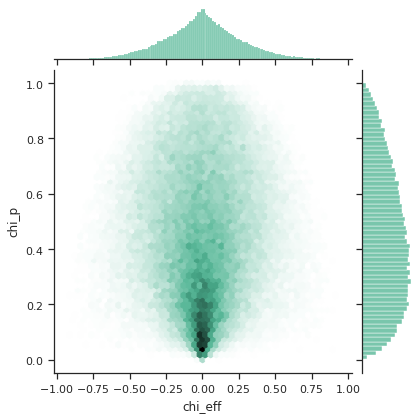

In [8]:
x = posteriors[0]["chi_eff"]
y = posteriors[0]["chi_p"]

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
plt.show()

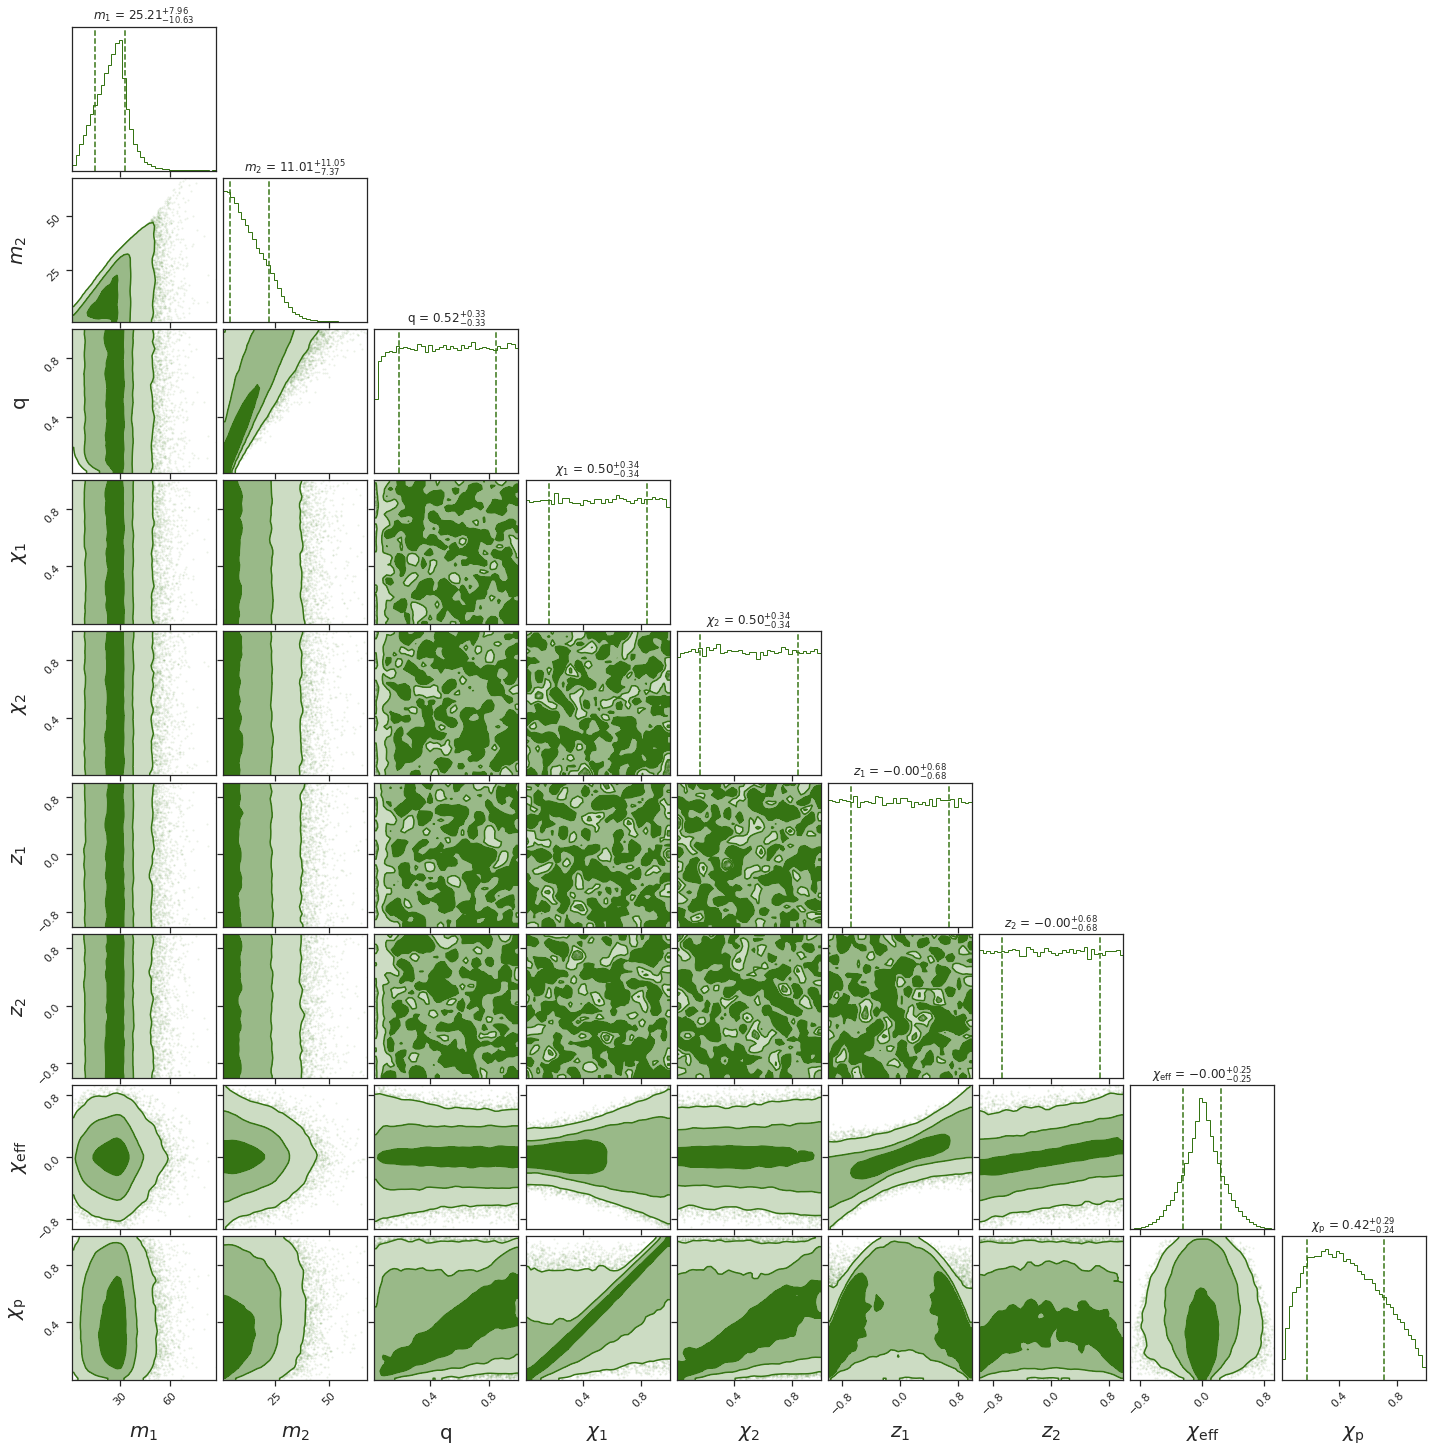

In [9]:
params = ['mass_1', 'mass_2', 'mass_ratio', 'a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'chi_eff', 'chi_p']
labels = ["$m_1$", "$m_2$", "q", "$\\chi_1$", "$\\chi_2$", "$z_1$", "$z_2$", 
          "$\\chi_{\mathrm{eff}}$","$\\chi_{\mathrm{p}}$"]

data1 = posteriors[0][params].values

figure1 = corner.corner(data1,color=colours[3],bins=40, smooth=0.9, label_kwargs=dict(fontsize=20), 
                        title_kwargs=dict(fontsize=12),quantiles=[0.16, 0.84],
                        levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                        plot_density=False, plot_datapoints=True, fill_contours=True,
                        max_n_ticks=3, labels=labels, hist_kwargs=dict(density=True), show_titles = True)

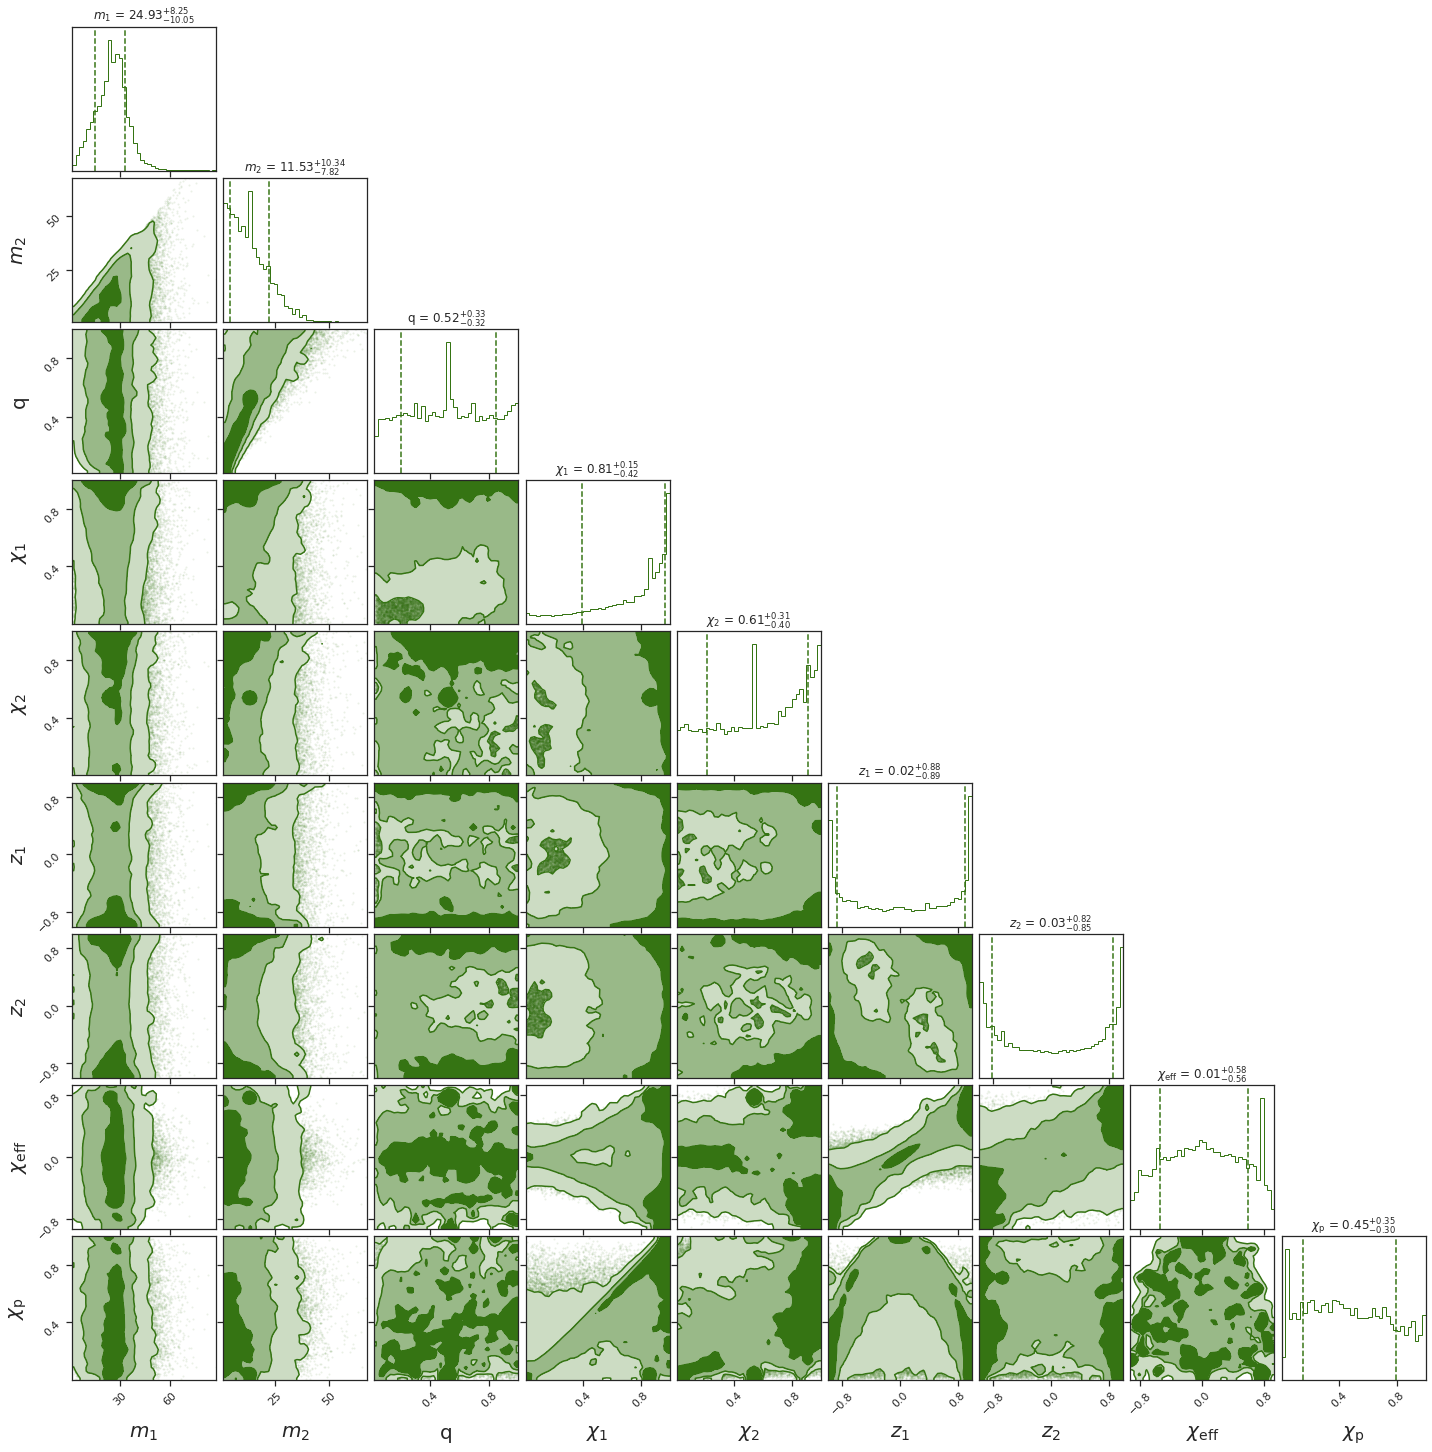

In [10]:
# With weights = 1/jp = 1/p(xeff, xp, q)

figure2 = corner.corner(data1,color=colours[3],bins=40, smooth=0.9, label_kwargs=dict(fontsize=20), 
                        weights = 1/posteriors[0]["jp"], 
                        show_titles = True, 
                        title_kwargs=dict(fontsize=12),quantiles=[0.16, 0.84],
                        levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                        plot_density=False, plot_datapoints=True, fill_contours=True,
                        max_n_ticks=3, labels=labels, hist_kwargs=dict(density=True))

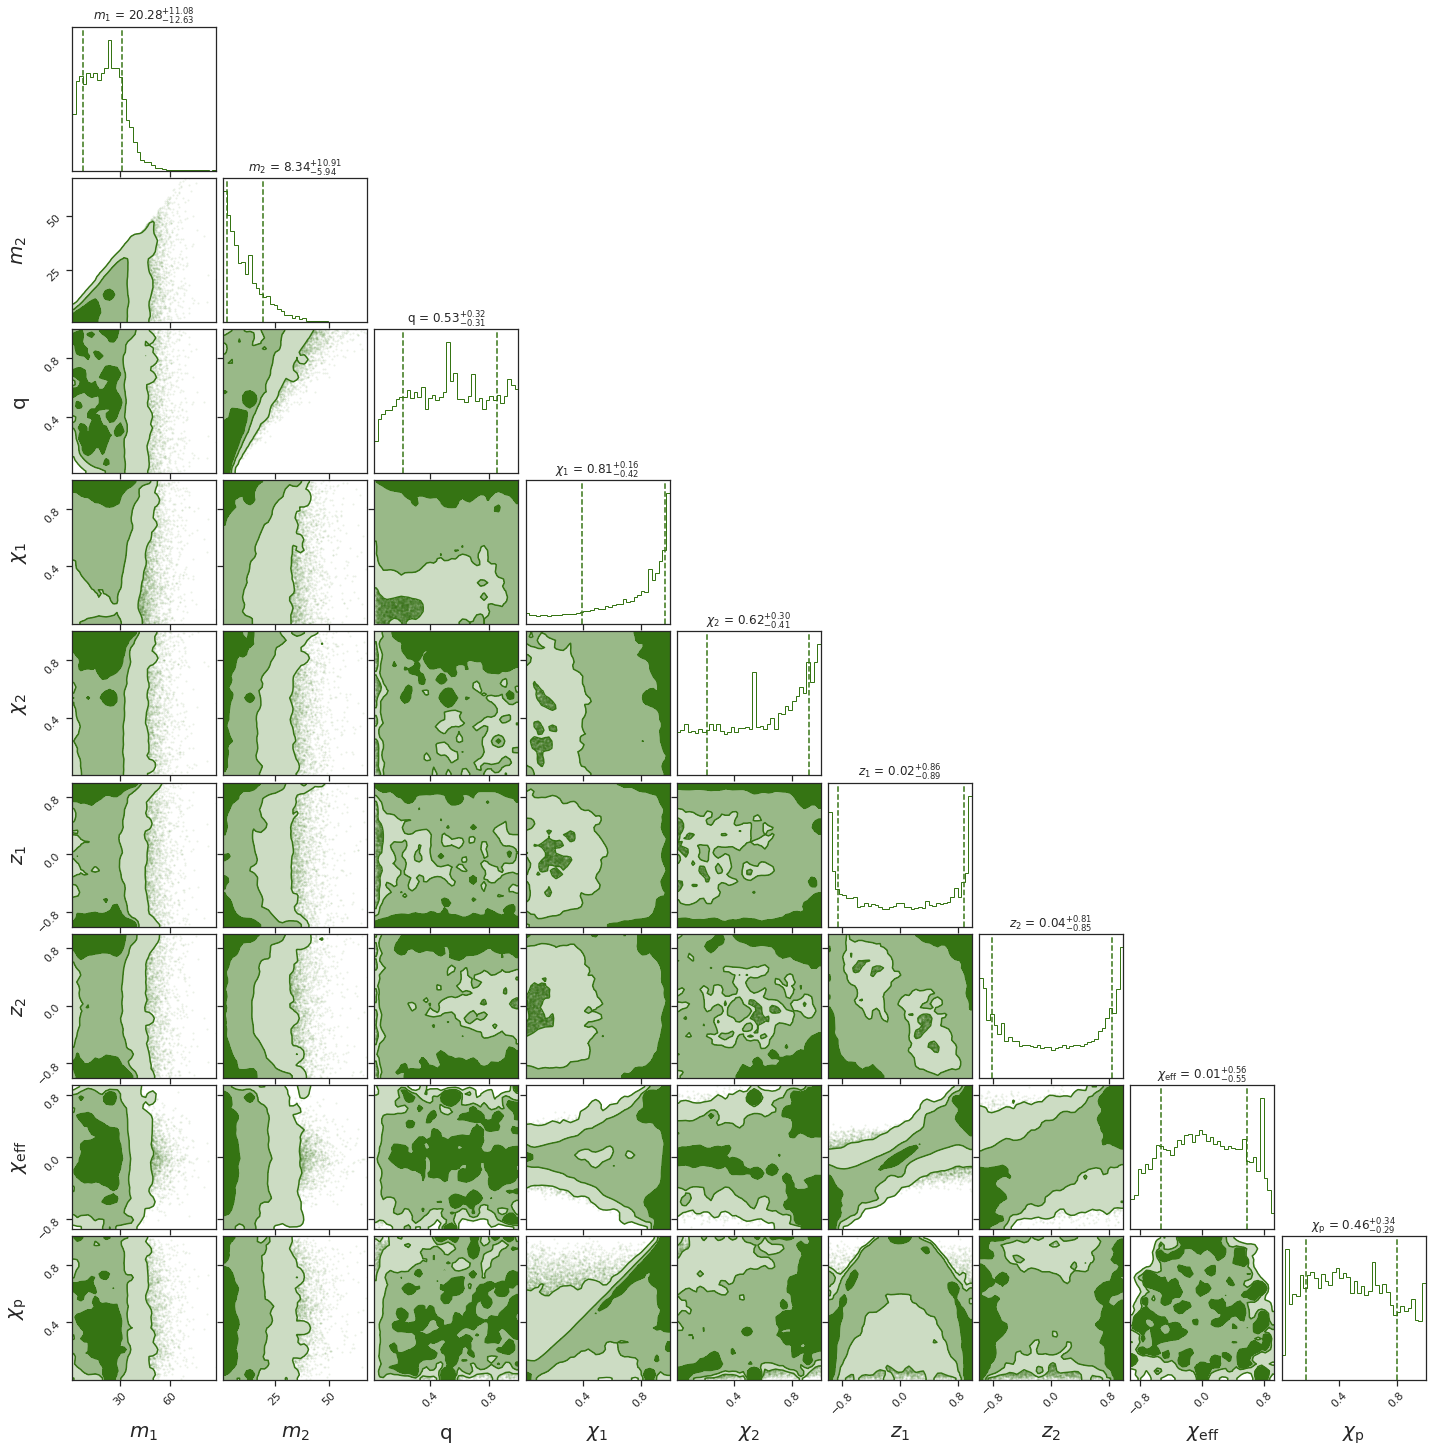

In [11]:
# With weight = 1/(p(xeff, xp, q) * p(m1, q))

figure3 = corner.corner(data1,color=colours[3],bins=40, smooth=0.9, label_kwargs=dict(fontsize=20), 
                        weights = 1/posteriors[0]["mass_jp"], 
                        show_titles = True, 
                        title_kwargs=dict(fontsize=12),quantiles=[0.16, 0.84],
                        levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                        plot_density=False, plot_datapoints=True, fill_contours=True,
                        max_n_ticks=3, labels=labels, hist_kwargs=dict(density=True))

In [ ]:
Done?

In [12]:
# Hyperparameter Estimation
# Using only Gaussian spin model
# Sampling pdf = p(chi_eff, chi_p, q)
# Using only one of the posterior samples

for posterior in posteriors:
    posterior["prior"] = posterior["jp"]

model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = [posteriors[0]], 
                                                    hyper_prior = model)

likelihood.parameters.update(priors.sample())
print(likelihood.parameters)
print(likelihood.log_likelihood_ratio())

{'mu_chi_eff': -0.25298454080472377, 'sigma_chi_eff': 0.37017656257023146, 'mu_chi_p': 0.6881517617771257, 'sigma_chi_p': 0.9763375436805546, 'spin_covariance': -0.511183581550805}
-0.15821897356851444


In [13]:
result_spin = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                                nlive = 1000, label = "gaussian_spin", outdir = "gaussian_spin", clean = True)

12:38 bilby INFO    : Running for label 'gaussian_spin', output will be saved to 'gaussian_spin'
12:38 bilby INFO    : Search parameters:
12:38 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
12:38 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
12:38 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
12:38 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
12:38 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
12:38 bilby INFO    : Single likelihood evaluation took 4.257e-03 s


0it [00:00, ?it/s]

12:38 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f60a555dee0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:38 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:38 bilby INFO    : Using dynesty version 1.0.1
12:38 bilby INFO    : Using the bilby-implemented rwalk sam

12:40 bilby INFO    : Sampling time: 0:01:50.433550
12:40 bilby INFO    : Summary of results:
nsamples: 4297
ln_noise_evidence:    nan
ln_evidence:    nan +/-    nan
ln_bayes_factor: -0.162 +/-    nan



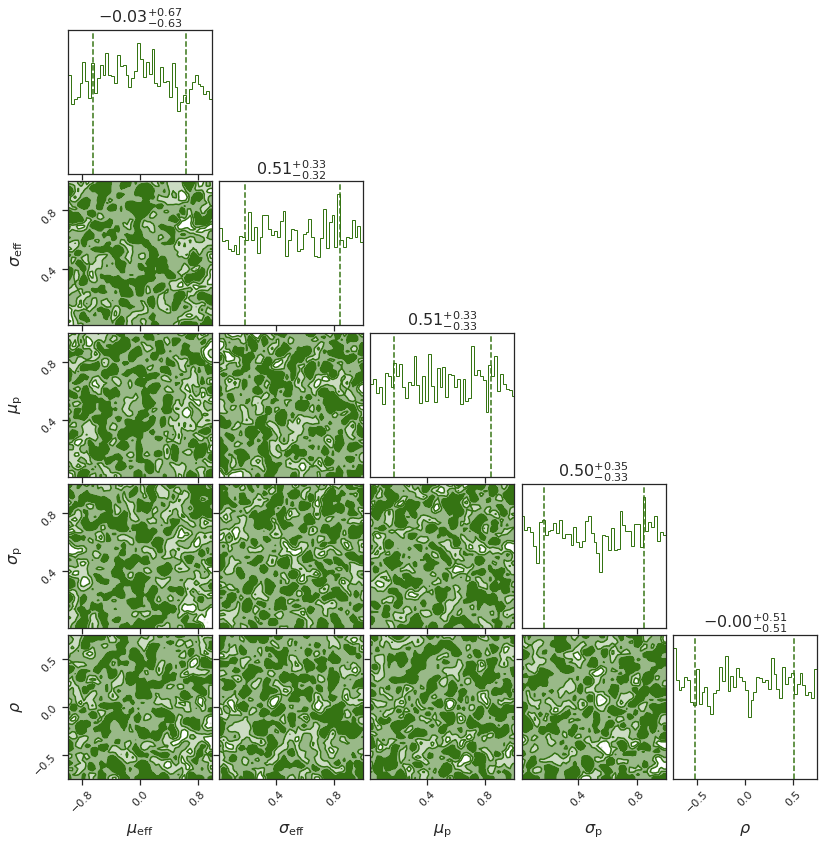

In [14]:
result_spin.plot_corner(color = colours[3])

In [15]:
# Hyperparameter Estimation
# Using only Gaussian spin model
# Sampling pdf = p(chi_eff, chi_p, q)
# Using all of the posterior samples (nevents = 10)

model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model)

likelihood.parameters.update(priors.sample())
print(likelihood.parameters)
print(likelihood.log_likelihood_ratio())

{'mu_chi_eff': 0.9908886583428076, 'sigma_chi_eff': 0.046831740857803825, 'mu_chi_p': 0.6904442876151171, 'sigma_chi_p': 0.34958684808233725, 'spin_covariance': 0.6550292656320089}
-7.797450747367998


In [ ]:
result_spin = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                                nlive = 1000, label = "gaussian_spin", outdir = "gaussian_spin", clean = True)

12:42 bilby INFO    : Running for label 'gaussian_spin', output will be saved to 'gaussian_spin'
12:42 bilby INFO    : Search parameters:
12:42 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
12:42 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
12:42 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
12:42 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
12:42 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
12:42 bilby INFO    : Single likelihood evaluation took 3.034e-03 s


0it [00:00, ?it/s]

12:42 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f608f040100>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:42 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:42 bilby INFO    : Using dynesty version 1.0.1
12:42 bilby INFO    : Using the bilby-implemented rwalk sam

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1831, reject=3170, and nfail=3028 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1772, reject=3229, and nfail=4201 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1786, reject=3215, and nfail=4054 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1601, reject=3400, and nfail=4555 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1262, reject=3739, and nfail=5467 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1252, reject=3749, and nfail=4930 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1113, reject=3888, and nfail=4927 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1166, reject=3835, and nfail=5615 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2497, reject=2504, and nfail=2906 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1996, reject=3005, and nfail=4816 try increasing maxmcmc
  warnings.warn(
15:44 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=3139, reject=1862, and nfail=1930 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=902, reject=4099, and nfail=6804 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1232, reject=3769, and nfail=6469 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1708, reject=3293, and nfail=3868 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1569, reject=3432, and nfail=4280 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1754, reject=3247, and nfail=5227 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2546, reject=2455, and nfail=3623 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=519, reject=4482, and nfail=6091 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2267, reject=2734, and nfail=3216 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1442, reject=3559, and nfail=5402 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2299, reject=2702, and nfail=3486 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=3109, reject=1892, and nfail=2395 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2418, reject=2583, and nfail=3602 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1433, reject=3568, and nfail=5186 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1753, reject=3248, and nfail=4443 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1475, reject=3526, and nfail=4669 try increasing maxmcmc
  warnings.warn(
16:35 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2253, reject=2748, and nfail=4077 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=809, reject=4192, and nfail=7764 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1709, reject=3292, and nfail=5249 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=418, reject=4583, and nfail=9529 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2126, reject=2875, and nfail=6132 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1157, reject=3844, and nfail=9629 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1132, reject=3869, and nfail=6029 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2121, reject=2880, and nfail=3597 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2009, reject=2992, and nfail=6444 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1958, reject=3043, and nfail=5377 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1433, reject=3568, and nfail=5338 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1356, reject=3645, and nfail=5615 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1453, reject=3548, and nfail=4992 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1449, reject=3552, and nfail=7117 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=734, reject=4267, and nfail=10426 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=768, reject=4233, and nfail=9804 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=875, reject=4126, and nfail=9462 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1912, reject=3089, and nfail=4211 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2582, reject=2419, and nfail=3768 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1611, reject=3390, and nfail=4912 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=946, reject=4055, and nfail=8175 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=921, reject=4080, and nfail=8290 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1307, reject=3694, and nfail=9420 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2487, reject=2514, and nfail=4424 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1090, reject=3911, and nfail=6978 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1140, reject=3861, and nfail=6923 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=898, reject=4103, and nfail=8950 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=554, reject=4447, and nfail=8320 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1295, reject=3706, and nfail=7792 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1473, reject=3528, and nfail=5312 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2629, reject=2372, and nfail=3818 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2669, reject=2332, and nfail=3423 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1462, reject=3539, and nfail=4710 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=971, reject=4030, and nfail=8621 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1195, reject=3806, and nfail=8043 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1909, reject=3092, and nfail=4788 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1528, reject=3473, and nfail=5865 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1522, reject=3479, and nfail=6253 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1244, reject=3757, and nfail=7154 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2873, reject=2128, and nfail=2991 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1233, reject=3768, and nfail=6063 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1716, reject=3285, and nfail=5533 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2705, reject=2296, and nfail=3018 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1409, reject=3592, and nfail=6409 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=828, reject=4173, and nfail=7921 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=807, reject=4194, and nfail=8092 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1063, reject=3938, and nfail=3334 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1292, reject=3709, and nfail=4069 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2316, reject=2685, and nfail=4588 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2067, reject=2934, and nfail=5062 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1017, reject=3984, and nfail=5913 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=987, reject=4014, and nfail=5949 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1084, reject=3917, and nfail=6430 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1591, reject=3410, and nfail=7078 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1169, reject=3832, and nfail=6032 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1030, reject=3971, and nfail=8857 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1708, reject=3293, and nfail=6265 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=589, reject=4412, and nfail=10710 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=608, reject=4393, and nfail=10254 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=671, reject=4330, and nfail=10155 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=749, reject=4252, and nfail=10269 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1912, reject=3089, and nfail=6456 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=994, reject=4007, and nfail=6937 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1045, reject=3956, and nfail=5876 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2866, reject=2135, and nfail=2680 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1367, reject=3634, and nfail=6966 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=673, reject=4328, and nfail=12302 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1215, reject=3786, and nfail=6863 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1114, reject=3887, and nfail=6553 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=743, reject=4258, and nfail=9525 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=855, reject=4146, and nfail=8333 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=895, reject=4106, and nfail=9765 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=597, reject=4404, and nfail=9502 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=413, reject=4588, and nfail=3981 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1615, reject=3386, and nfail=6039 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=603, reject=4398, and nfail=8884 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=898, reject=4103, and nfail=7584 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=862, reject=4139, and nfail=6976 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1207, reject=3794, and nfail=4922 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=924, reject=4077, and nfail=6797 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=788, reject=4213, and nfail=8201 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2107, reject=2894, and nfail=4089 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1421, reject=3580, and nfail=7407 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1823, reject=3178, and nfail=6936 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=879, reject=4122, and nfail=8187 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1085, reject=3916, and nfail=4993 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=915, reject=4086, and nfail=8215 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=714, reject=4287, and nfail=8516 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2075, reject=2926, and nfail=4889 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1212, reject=3789, and nfail=8643 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1864, reject=3137, and nfail=4135 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1200, reject=3801, and nfail=4421 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1192, reject=3809, and nfail=5681 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=508, reject=4493, and nfail=10352 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=575, reject=4426, and nfail=9412 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=619, reject=4382, and nfail=11081 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=484, reject=4517, and nfail=12284 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1620, reject=3381, and nfail=8403 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1729, reject=3272, and nfail=6623 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=565, reject=4436, and nfail=9896 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=655, reject=4346, and nfail=9827 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=537, reject=4464, and nfail=12141 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1654, reject=3347, and nfail=5900 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1833, reject=3168, and nfail=3434 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1444, reject=3557, and nfail=4980 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=584, reject=4417, and nfail=14323 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=12, reject=4989, and nfail=16312 try increasing maxmcmc
  warnings.warn(
21:55 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarni

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=725, reject=4276, and nfail=11015 try increasing maxmcmc
  warnings.warn(
22:06 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=745, reject=4256, and nfail=10563 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1279, reject=3722, and nfail=4770 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2333, reject=2668, and nfail=2766 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2172, reject=2829, and nfail=4382 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2247, reject=2754, and nfail=2946 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1129, reject=3872, and nfail=6327 try 

22:26 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1533, reject=3468, and nfail=5584 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1496, reject=3505, and nfail=4161 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1356, reject=3645, and nfail=5413 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=795, reject=4206, and nfail=8860 try increasing maxmcmc
  warnings.warn(
22:37 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1592, reject=3409, and nfail=5113 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=451, reject=4550, and nfail=12450 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarni

22:47 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=442, reject=4559, and nfail=15855 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=491, reject=4510, and nfail=15690 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=522, reject=4479, and nfail=14810 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1367, reject=3634, and nfail=4955 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1037, reject=3964, and nfail=9793 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1346, reject=3655, and nfail=5465 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1613, reject=3388, and nfail=4127 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=825, reject=4176, and nfail=8088 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=595, reject=4406, and nfail=11711 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=958, reject=4043, and nfail=5932 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2330, reject=2671, and nfail=4875 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=838, reject=4163, and nfail=7712 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1017, reject=3984, and nfail=7572 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=774, reject=4227, and nfail=9705 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1524, reject=3477, and nfail=4290 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=863, reject=4138, and nfail=8936 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=559, reject=4442, and nfail=10733 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=623, reject=4378, and nfail=10859 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=696, reject=4305, and nfail=9748 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1497, reject=3504, and nfail=5484 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1686, reject=3315, and nfail=5487 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1469, reject=3532, and nfail=6402 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1392, reject=3609, and nfail=4932 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1267, reject=3734, and nfail=6038 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1006, reject=3995, and nfail=6850 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=956, reject=4045, and nfail=9185 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1183, reject=3818, and nfail=6313 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2069, reject=2932, and nfail=4403 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=654, reject=4347, and nfail=10349 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1662, reject=3339, and nfail=3483 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=897, reject=4104, and nfail=7469 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1153, reject=3848, and nfail=7179 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1071, reject=3930, and nfail=7688 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1207, reject=3794, and nfail=7409 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=945, reject=4056, and nfail=8984 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=863, reject=4138, and nfail=12252 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=729, reject=4272, and nfail=13673 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=923, reject=4078, and nfail=11226 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=916, reject=4085, and nfail=11193 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1007, reject=3994, and nfail=9032 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=946, reject=4055, and nfail=9439 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1112, reject=3889, and nfail=6989 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=964, reject=4037, and nfail=8689 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1112, reject=3889, and nfail=7422 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1117, reject=3884, and nfail=7826 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1425, reject=3576, and nfail=6551 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1459, reject=3542, and nfail=3021 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1477, reject=3524, and nfail=5927 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1686, reject=3315, and nfail=3753 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1004, reject=3997, and nfail=7040 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1283, reject=3718, and nfail=5880 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1320, reject=3681, and nfail=5857 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1099, reject=3902, and nfail=6493 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=544, reject=4457, and nfail=12478 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1061, reject=3940, and nfail=8061 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1468, reject=3533, and nfail=4786 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2117, reject=2884, and nfail=4982 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1019, reject=3982, and nfail=7999 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2125, reject=2876, and nfail=3748 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=593, reject=4408, and nfail=13719 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1025, reject=3976, and nfail=7103 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1491, reject=3510, and nfail=5766 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1555, reject=3446, and nfail=5852 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1057, reject=3944, and nfail=7508 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=924, reject=4077, and nfail=8077 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1601, reject=3400, and nfail=4614 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=949, reject=4052, and nfail=7100 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1075, reject=3926, and nfail=7445 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1098, reject=3903, and nfail=7186 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1306, reject=3695, and nfail=6876 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1004, reject=3997, and nfail=5737 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1278, reject=3723, and nfail=6783 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1098, reject=3903, and nfail=7525 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1146, reject=3855, and nfail=9007 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2347, reject=2654, and nfail=3708 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1770, reject=3231, and nfail=5234 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1431, reject=3570, and nfail=5010 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1012, reject=3989, and nfail=8671 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=10, reject=4991, and nfail=17821 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1262, reject=3739, and nfail=6415 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1170, reject=3831, and nfail=6515 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1123, reject=3878, and nfail=7843 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1317, reject=3684, and nfail=7020 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1, reject=5000, and nfail=15105 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1125, reject=3876, and nfail=8421 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=10, reject=4991, and nfail=19371 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1443, reject=3558, and nfail=6106 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=743, reject=4258, and nfail=8484 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2256, reject=2745, and nfail=4250 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=529, reject=4472, and nfail=11258 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=674, reject=4327, and nfail=10376 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=811, reject=4190, and nfail=8662 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1334, reject=3667, and nfail=5233 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=7, reject=4994, and nfail=19438 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1077, reject=3924, and nfail=6127 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=955, reject=4046, and nfail=8484 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=691, reject=4310, and nfail=11256 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1554, reject=3447, and nfail=4959 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1393, reject=3608, and nfail=5291 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1484, reject=3517, and nfail=4361 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=11, reject=4990, and nfail=19668 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=956, reject=4045, and nfail=8195 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=946, reject=4055, and nfail=8398 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=787, reject=4214, and nfail=8377 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=615, reject=4386, and nfail=11170 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1238, reject=3763, and nfail=8909 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=665, reject=4336, and nfail=11146 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1465, reject=3536, and nfail=3448 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=700, reject=4301, and nfail=10454 try increasing maxmcmc
  warnings.warn(
03:42 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=941, reject=4060, and nfail=10521 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarn

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=703, reject=4298, and nfail=9604 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1013, reject=3988, and nfail=6837 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=619, reject=4382, and nfail=11213 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=763, reject=4238, and nfail=7706 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1364, reject=3637, and nfail=6109 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1544, reject=3457, and nfail=6022 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=521, reject=4480, and nfail=11860 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=499, reject=4502, and nfail=14208 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1916, reject=3085, and nfail=3194 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=731, reject=4270, and nfail=8391 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1303, reject=3698, and nfail=6434 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1041, reject=3960, and nfail=5807 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1011, reject=3990, and nfail=6047 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=677, reject=4324, and nfail=10240 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1091, reject=3910, and nfail=6776 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=700, reject=4301, and nfail=9617 try i

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=465, reject=4536, and nfail=14010 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1213, reject=3788, and nfail=5411 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1017, reject=3984, and nfail=7371 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1275, reject=3726, and nfail=6583 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=801, reject=4200, and nfail=6701 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=985, reject=4016, and nfail=6708 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1391, reject=3610, and nfail=6699 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=805, reject=4196, and nfail=8487 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=834, reject=4167, and nfail=9052 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=987, reject=4014, and nfail=6359 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=922, reject=4079, and nfail=8857 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=933, reject=4068, and nfail=8671 try incr

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=608, reject=4393, and nfail=9054 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=633, reject=4368, and nfail=9374 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=683, reject=4318, and nfail=8995 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=869, reject=4132, and nfail=10019 try inc

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=729, reject=4272, and nfail=9185 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1056, reject=3945, and nfail=6956 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1703, reject=3298, and nfail=3140 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=979, reject=4022, and nfail=6107 try in

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1192, reject=3809, and nfail=6892 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2341, reject=2660, and nfail=3052 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1429, reject=3572, and nfail=6214 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2737, reject=2264, and nfail=4092 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1027, reject=3974, and nfail=7892 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1019, reject=3982, and nfail=9549 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=812, reject=4189, and nfail=10158 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=793, reject=4208, and nfail=10122 try 

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=2002, reject=2999, and nfail=4093 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=728, reject=4273, and nfail=9699 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=1690, reject=3311, and nfail=5182 try increasing maxmcmc
  warnings.warn(
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby-1.1.0-py3.8.egg/bilby/core/sampler/dynesty.py:795: UserWarning: Hit maximum number of walks 5000 with accept=959, reject=4042, and nfail=7818 try in

05:53 bilby INFO    : Run interrupted by signal 2: checkpoint and exit on 130
05:53 bilby INFO    : Written checkpoint file gaussian_spin/gaussian_spin_resume.pickle
05:53 bilby INFO    : Writing 3131 current samples to gaussian_spin/gaussian_spin_samples.dat


In [ ]:
result_spin.plot_corner(color = colours[3])

In [14]:
# Using Gaussian spin model with Truncated mass model; Sampling pdf = p(chi_eff, chi_p, q) * p(m1, q)

for posterior in posteriors:
    posterior["prior"] = posterior["mass_jp"]

model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio])

priors = PriorDict()

# mass 
priors["alpha"] = Uniform(minimum = -4, maximum = 12, latex_label = r'$\alpha$')
priors["beta"] = Uniform(minimum = -4, maximum = 12, latex_label = r'$\beta_\mathrm{q}$')
priors["mmin"] = Uniform(minimum = 2, maximum = 10, latex_label = r'$M_\mathrm{min}$')
priors["mmax"] = Uniform(minimum = 30, maximum = 100, latex_label = r'$M_\mathrm{max}$')

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors,
                                                    hyper_prior = model)

likelihood.parameters.update(priors.sample())
print(likelihood.parameters)
print(likelihood.log_likelihood_ratio())

{'alpha': 5.9604022787665, 'beta': 8.844794335922865, 'mmin': 4.405520118390928, 'mmax': 57.72111764335316, 'mu_chi_eff': -0.8847662766198698, 'sigma_chi_eff': 0.38570246058546853, 'mu_chi_p': 0.8765714978271557, 'sigma_chi_p': 0.7409752793490011, 'spin_covariance': -0.06495591885975971}
2.136809289890003


In [ ]:
result_spin_mass = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                                     nlive = 1000, label = "gaussian_spin_mass", outdir = "gaussian_spin_mass",
                                     clean = True)

01:46 bilby INFO    : Running for label 'gaussian_spin_mass', output will be saved to 'gaussian_spin_mass'
01:46 bilby INFO    : Search parameters:
01:46 bilby INFO    :   alpha = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
01:46 bilby INFO    :   beta = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta_\\mathrm{q}$', unit=None, boundary=None)
01:46 bilby INFO    :   mmin = Uniform(minimum=2, maximum=10, name=None, latex_label='$M_\\mathrm{min}$', unit=None, boundary=None)
01:46 bilby INFO    :   mmax = Uniform(minimum=30, maximum=100, name=None, latex_label='$M_\\mathrm{max}$', unit=None, boundary=None)
01:46 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
01:46 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
01:46 bilby INFO    :   mu_chi_p =

0it [00:00, ?it/s]

01:46 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa4e836a670>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
01:46 bilby INFO    : Checkpoint every check_point_delta_t = 600s
01:46 bilby INFO    : Using dynesty version 1.0.1
01:46 bilby INFO    : Using the bilby-implemented rwalk sam

In [ ]:
result_spin_mass.plot_corner(color = colours[3])